In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
384593,197727,59869.0454,4,13.523948,1.927781,1,3.938479,1
6819137,215458,59646.0731,1,39.695175,1.590885,1,3.675929,0
2843002,91035,60654.0859,4,79.856606,2.403307,1,3.938479,1
3426969,109719,60211.0390,4,21.841459,3.494957,1,3.938479,0
7189141,227476,59864.0316,3,55.991722,1.465493,1,3.875155,1
2575338,82374,60165.1524,3,90.695671,1.489765,1,3.875155,1
103530,55419,59649.0640,3,96.173729,2.180619,1,3.875155,0
4989421,158663,60240.0223,2,47.148602,2.058619,1,3.790512,0
2500737,80026,59797.3126,4,15.584802,2.797649,1,3.938479,0
5454791,173240,60593.0901,4,43.325043,2.012418,1,3.938479,0


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

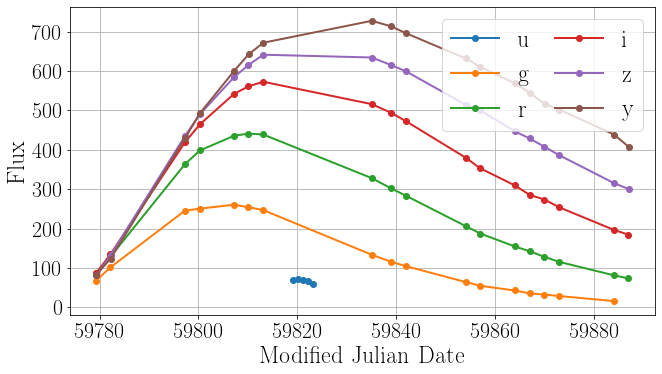

In [7]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

(4, 360, 648)


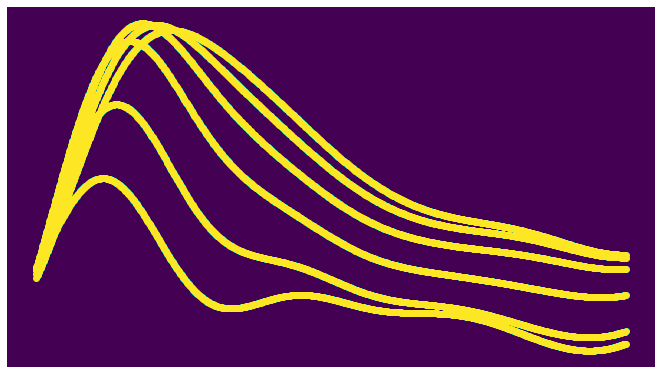

In [12]:
from sklearn.model_selection import train_test_split
import gp_aug

anobject = aug_functions.get_object(good_objects_df, 19213)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), n_obs=1000)

fig = plt.figure(figsize=(9, 5), tight_layout = {'pad': 0})
ax = fig.add_subplot(111, aspect='auto')

for i in range(len(aug_functions.passband2lam)):
    plt.plot(t_aug[i*1000:(i+1)*1000], flux_aug[i*1000:(i+1)*1000], '-o')

#plt.xlabel('Modified Julian Date', fontsize=24)
#plt.xticks(fontsize=22)
#plt.ylabel('Flux', fontsize=24)
#plt.yticks(fontsize=22)
#plt.legend(loc='best', ncol=2, fontsize=24, columnspacing=1.0)
#plt.grid(True)
#plt.show()
#fig.savefig("../pictures/light_curve_{}_aug.pdf".format(19213))
ax.set_axis_off()
fig.canvas.draw()

buf = fig.canvas.buffer_rgba()
data_array = np.transpose(np.asarray(buf), (2, 0, 1)).copy()
print(data_array.shape)
plt.imshow(data_array[3])
plt.show()

In [21]:
augmentation_model = "MLP"

In [22]:
from tqdm import tqdm_notebook
from tqdm import tqdm

all_data = []
all_target_classes = []
for good_id in tqdm(good_object_ids):
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # fit augmentation model
    model = None
    if augmentation_model == "GP":
        import gp_aug
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_single":
        import single_layer_aug
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        import features_aug
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        import mlp_reg_aug
        model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type: {}".format(augmentation_model))

    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), n_obs=1000)

    fig = plt.figure(figsize=(9, 5), tight_layout={'pad': 0})
    ax = fig.add_subplot(111, aspect='auto')

    for i in range(len(aug_functions.passband2lam)):
        plt.plot(t_aug[i*1000:(i+1)*1000], flux_aug[i*1000:(i+1)*1000], '-o')

    ax.set_axis_off()
    fig.canvas.draw()
    data_array = np.transpose(fig.canvas.buffer_rgba(), (2, 0, 1))
    all_data.append(data_array.copy())
    plt.close()
    
    true_class = int(anobject['class'].to_numpy()[0])
    all_target_classes.append(true_class)
    
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)

 58%|█████▊    | 1455/2508 [05:01<03:37,  4.83it/s]  


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    np.array(all_target_classes),
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input
X_train_norm = np.array(X_train, dtype=np.float32) / 255 - 0.5
X_test_norm = np.array(X_test, dtype=np.float32) / 255 - 0.5

X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(y_train)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(y_test)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16 * 88 * 160, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 16 * 88 * 160)
        
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [18]:
import torch.optim as optim

net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

    return correct / total

In [20]:
for epoch in tqdm_notebook(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    print('[%5d] error: %.3f' % (epoch + 1, cur_loss))

print('Finished Training')

[    1] error: 0.645

Finished Training


In [21]:
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %d%%' % 
      (X_test_norm.shape[0], round(100 * test_accuracy)))
print('Train accuracy of the network on the %d train images: %d%%' % 
      (X_test_norm.shape[0], round(100 * train_accuracy)))

Test accuracy of the network on the 207 test images: 71%
Train accuracy of the network on the 207 train images: 82%


In [22]:
test_score_sgd = [0.71, 0.71, 0.71, 0.74, 0.73, 0.77, 0.74, 0.74, 0.75, 0.76]
train_score_sgd = [0.82, 0.92, 0.87, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

test_score_adam = [0.69, 0.78, 0.73, 0.76, 0.76, 0.76, 0.76, 0.78, 0.81, 0.8]
train_score_adam = [0.84, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

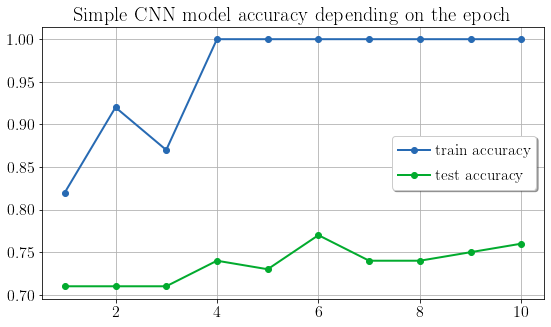

In [23]:
epochs = np.arange(10)

fig = plt.figure(figsize=(9, 5))
plt.title("Simple CNN model accuracy depending on the epoch", fontsize=20)
plt.plot(epochs + 1, train_score_sgd, "-o", color="xkcd:mid blue", label="train accuracy", lw=2)
plt.plot(epochs + 1, test_score_sgd, "-o", color="xkcd:kelly green", label="test accuracy", lw=2)
plt.legend(loc="best", fontsize=16, handletextpad=0.3, shadow=0.1)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/simple_cnn_accuracy_sgd.pdf", bbox_inches='tight', pad_inches=0.01)

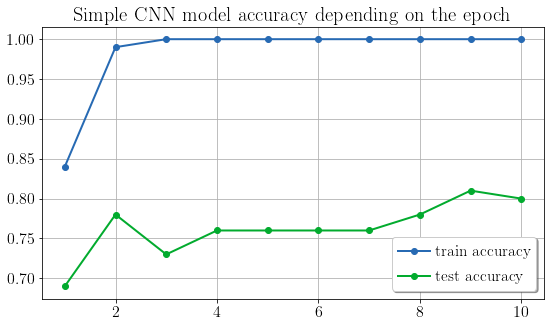

In [24]:
epochs = np.arange(10)

fig = plt.figure(figsize=(9, 5))
plt.title("Simple CNN model accuracy depending on the epoch", fontsize=20)
plt.plot(epochs + 1, train_score_adam, "-o", color="xkcd:mid blue", label="train accuracy", lw=2)
plt.plot(epochs + 1, test_score_adam, "-o", color="xkcd:kelly green", label="test accuracy", lw=2)
plt.legend(loc="best", fontsize=16, handletextpad=0.3, shadow=0.1)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/simple_cnn_accuracy_adam.pdf", bbox_inches='tight', pad_inches=0.01)

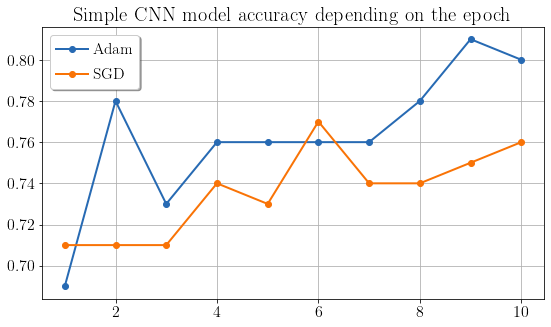

In [32]:
epochs = np.arange(10)

fig = plt.figure(figsize=(9, 5))
plt.title("Simple CNN model accuracy depending on the epoch", fontsize=20)
plt.plot(epochs + 1, test_score_adam, "-o", color="xkcd:mid blue", label="Adam", lw=2)
plt.plot(epochs + 1, test_score_sgd, "-o", color="xkcd:orange", label="SGD", lw=2)
plt.legend(loc="best", fontsize=16, handletextpad=0.3, shadow=0.1)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/simple_cnn_accuracy.pdf", bbox_inches='tight', pad_inches=0.01)